In [2]:
push!(LOAD_PATH, joinpath(Pkg.dir("SpectralClustering"), "docs"));

# Approximate embedding

## Spectral Gruping using  Nystrom Method
It is possible obtain a approximation of the laplacian eigenvectors evaluating the simmiliarty of a small set of elements and then approximating the remaining affinites. Let be   $A \subset X$ a subset of sampled patterns and let $B = V - A$ be the rest of the non sampled patterns.   $W_A$ is the simmilarity matrix derived from the data contained in $A$ and $L_A$ is the laplacian matrix of  $W_A$.
  $W_B$ and $L_B$ are the matrices corresponding to the affinities of the patterns of $A$ and $B$. It is possible define $L$ as:
$$
  W=\def\arraystretch{1.5}
  \begin{bmatrix}
    W_A & W_B \\
    W_B^T & W_C
  \end{bmatrix}
   L=\def\arraystretch{1.5}
  \begin{bmatrix}
    L_A & L_B \\
    L_B^T & L_C
  \end{bmatrix}
$$
  It can be obtained an approximation of $W$, called $\hat{W}$,  from  $A$ and   $B$:
  
$$
  \hat{W} = \bar{U}\Lambda \bar{U}^T
	      =  \begin{bmatrix} A   & B \\
				B^T & B^T A^{-1} B
		\end{bmatrix}
$$

  In order to obtain the eigenvectors of the approximate laplacian matrix,  $\hat{L} =  \hat{D}^{\frac{1}{2}} \hat{W}
  \hat{D}^{\frac{1}{2}}$,   $\hat{L_A}$ and  $\hat{L_B}$  have to be computed: 
$\hat{{L_A}_{ij}} = \frac{W_{A_{ij}}}{\sqrt{\hat{d}_i \hat{d}_j}}$ and $ \hat{{L_B}_{ij}}= \frac{W_{B_{ij}}}{\sqrt{\hat{d}_i \hat{d}_{j+|A|}}} $

 where $\hat{d} = \hat{W} \mathbf{1}$.  If $\hat{L_A}$ is positive definite, it is possible to find an approximation of the orthogonals eigevectors in a single step. Let be  $ S=\hat{L_{A}} + \hat{L_{A}}^{-\frac{1}{2}}\hat{L_{B}}\hat{L_{B}}^T
\hat{L_{A}}^{-\frac{1}{2}} $ and its diagonalization  $S=U_S \Lambda_S U_S^T$,   [Fowkles et al.](#fowlkes2004spectral)  showed that if the matrix $V$ is defined as

$$  
  V=\begin{bmatrix} \hat{L_A} \\ \hat{L_B}^T \end{bmatrix}
  \hat{L_A}^{-\frac{1}{2}} U_S \Lambda_S^{-\frac{1}{2}}  
$$

  $\hat{L}$ is diagonalized by  $V$ and by $\Lambda_S$ y $V^T V = I$

The `NystromMethod` type allows to obtain approximate eigenvectors. The following things have to be defined in order to instatiante this type:
- A method to sample points Landmark Selection.
- The number of points to be sampled.
- The simmilarity function between patterns.
- The number of eigevectors to obtain.

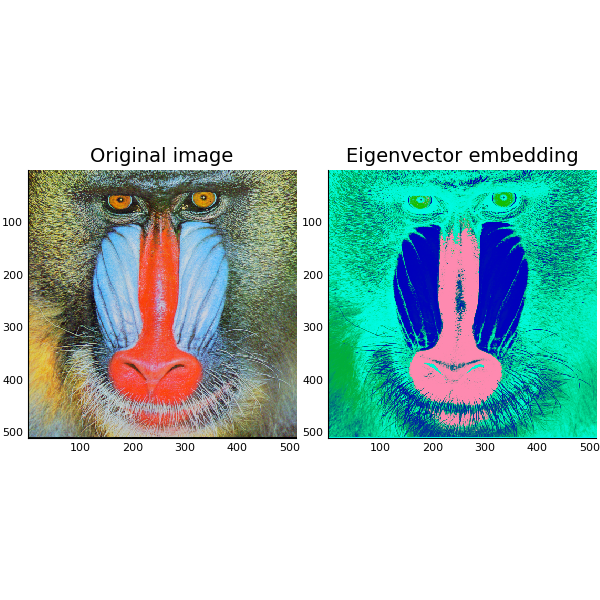

In [2]:
using TestImages,  Images, Plots, Clustering,  SpectralClustering, Distances, Extras 
pyplot()
function weight(i::Integer,j::Vector{<:Integer},pixel_i, neighbors_data)
    return vec(prod(exp.(-abs.(pixel_i[3:5].-neighbors_data[3:5,:])./(2*0.1^2)),1))
end
img                      = testimage("mandrill")
number_of_pixels         = size(img,1)*size(img,2)
number_of_sampled_points = round(Int,number_of_pixels * 0.005)
nvec                     = 3
knnconfig                = PixelNeighborhood(3)
nystrom                  = NystromMethod(
                              EvenlySpacedLandmarkSelection(),
                              number_of_sampled_points,
                              weight,
                              nvec,
                              false)
embedded_patterns        = embedding(nystrom, img)
img_embedded             = Extras.embedded_image(size(img), embedded_patterns)
plt1 = Plots.plot(img_embedded, title="Eigenvector embedding") 
plt2 = Plots.plot(img, title ="Original image")
Plots.plot(plt2, plt1, layout=(@layout grid(1,2)) , size=(600,600))

## DNCuts
In [Multiscale Combinatorial Grouping for Image Segmentation and Object Proposal Generation](#pont2017multiscale) the authors presented a a technique for approximating the eigenvectors in a very efficiently way.
Their algorithm is based in two observations:
- The eigenvectors of the Laplacian $L$ are the same as the eigenvectors of $A^2$
- The eigenvectors of a downsampled version of L should be similar to the eigenvectors of $L$.

The idea is to decimate the simmiliraty matrix to obtain $W[i,i]$. This matrix is obtained by removing the rows and columns corresponding to the pixels in every even column  and every even row of the image. The next step is propagate the affinities $W[i,i]$ by squaring the matrix. This procedure is carried for a few iterations. Then the eigenvectors of the last version of the decimated matrix is obtained. And finally the eigenvectors are upsampled to the original size. 

Their technique "is similar to Nystrom’s method for computing the eigenvectors of a subset of A, but our squaring-and-decimation procedure means that we do not depend on long-range connections between pixels."

In [5]:
using Clustering, Images, TestImages, SpectralClustering,Distances,Extras, Plots, LightGraphs
pyplot()
function weight(i::Integer,j::Vector{<:Integer},pixel_i, neighbors_data)
    return vec(prod(exp.(-abs.(pixel_i[3:5].-neighbors_data[3:5,:])./(2*0.1^2)),1))
end
img          = testimage("mandrill");
nconfig      = PixelNeighborhood(2);
graph        = create(nconfig,weight,  img);
nev          = 3
scales       = 2
dncuts       = DNCuts(scales, nev, size(img));
V            = embedding(dncuts, adjacency_matrix(graph));
img_embedded = Extras.embedded_image(size(img), V)
plt1 = Plots.plot(img_embedded)
plt2 = Plots.plot(img)
Plots.plot(plt2, plt1, layout=(@layout grid(1,2)) , size=(600,600))


  0.006887 seconds (13 allocations: 4.536 MiB)
  0.007444 seconds (7 allocations: 24.383 MiB, 38.67% gc time)
  0.115717 seconds (46 allocations: 142.359 MiB, 62.92% gc time)
  0.000000 seconds (1 allocation: 48 bytes)
  0.769556 seconds (196.63 k allocations: 87.650 MiB, 94.58% gc time)
  0.000007 seconds (5 allocations: 96 bytes)
  0.001820 seconds (12 allocations: 1.137 MiB)
  0.001230 seconds (7 allocations: 6.317 MiB)
  0.673728 seconds (46 allocations: 36.806 MiB, 98.65% gc time)
  0.000000 seconds
  0.076139 seconds (49.18 k allocations: 22.576 MiB, 86.39% gc time)
  0.000010 seconds (3 allocations: 64 bytes)

  [1    ,     1]  =  0.145708
  [2    ,     1]  =  2.15716e-9
  [3    ,     1]  =  1.52375e-5
  [129  ,     1]  =  0.0190529
  [130  ,     1]  =  1.88008e-5
  [131  ,     1]  =  8.02361e-21
  [257  ,     1]  =  1.51103e-6
  [258  ,     1]  =  1.12487e-17
  [259  ,     1]  =  5.55425e-37
  [1    ,     2]  =  2.15716e-9
  [2    ,     2]  =  0.00279843
  [3    ,     2]  =  1.

  [152  ,    22]  =  5.77634e-22
  [276  ,    22]  =  7.84809e-39
  [277  ,    22]  =  9.79081e-11
  [278  ,    22]  =  8.64768e-10
  [279  ,    22]  =  3.10061e-7
  [280  ,    22]  =  7.0923e-34
  [21   ,    23]  =  6.71481e-17
  [22   ,    23]  =  4.52451e-9
  [23   ,    23]  =  0.000216545
  [24   ,    23]  =  1.24885e-6
  [25   ,    23]  =  2.05431e-8
  [149  ,    23]  =  1.45486e-17
  [150  ,    23]  =  3.6831e-9
  [151  ,    23]  =  2.87179e-9
  [152  ,    23]  =  5.62572e-5
  [153  ,    23]  =  5.94792e-19
  [277  ,    23]  =  1.31438e-25
  [278  ,    23]  =  1.5748e-12
  [279  ,    23]  =  1.13931e-10
  [280  ,    23]  =  1.32699e-11
  [281  ,    23]  =  1.27255e-22
  [22   ,    24]  =  1.12052e-17
  [23   ,    24]  =  1.24885e-6
  [24   ,    24]  =  0.0033748
  [25   ,    24]  =  3.91389e-8
  [26   ,    24]  =  4.47847e-14
  [150  ,    24]  =  4.01878e-12
  [151  ,    24]  =  0.000936921
  [152  ,    24]  =  3.51295e-6
  [153  ,    24]  =  4.68291e-11
  [154  ,    24]  =  3.62

  [297  ,    43]  =  9.93123e-47
  [298  ,    43]  =  1.20364e-6
  [299  ,    43]  =  0.000367129
  [300  ,    43]  =  5.8958e-15
  [301  ,    43]  =  3.38209e-19
  [42   ,    44]  =  2.18487e-8
  [43   ,    44]  =  0.000724151
  [44   ,    44]  =  0.000204932
  [45   ,    44]  =  8.2685e-7
  [46   ,    44]  =  8.63916e-15
  [170  ,    44]  =  1.68827e-28
  [171  ,    44]  =  1.03875e-15
  [172  ,    44]  =  9.08555e-9
  [173  ,    44]  =  9.11458e-8
  [174  ,    44]  =  3.04018e-29
  [298  ,    44]  =  8.26355e-47
  [299  ,    44]  =  1.14046e-16
  [300  ,    44]  =  2.13207e-15
  [301  ,    44]  =  8.91239e-14
  [302  ,    44]  =  2.14402e-32
  [43   ,    45]  =  6.47371e-8
  [44   ,    45]  =  8.2685e-7
  [45   ,    45]  =  0.00111731
  [46   ,    45]  =  4.4546e-6
  [47   ,    45]  =  3.36119e-9
  [171  ,    45]  =  1.44426e-15
  [172  ,    45]  =  0.000141887
  [173  ,    45]  =  0.000125961
  [174  ,    45]  =  2.61887e-6
  [175  ,    45]  =  3.08498e-12
  [299  ,    45]  =  9.79

  [319  ,    64]  =  3.41436e-5
  [320  ,    64]  =  1.01871e-5
  [321  ,    64]  =  2.5207e-9
  [322  ,    64]  =  2.41825e-14
  [63   ,    65]  =  8.1851e-10
  [64   ,    65]  =  2.54243e-5
  [65   ,    65]  =  0.0992324
  [66   ,    65]  =  0.00173819
  [67   ,    65]  =  5.12302e-9
  [191  ,    65]  =  1.28471e-12
  [192  ,    65]  =  0.000124452
  [193  ,    65]  =  0.0022067
  [194  ,    65]  =  0.000224687
  [195  ,    65]  =  2.90228e-9
  [319  ,    65]  =  6.66956e-14
  [320  ,    65]  =  3.74822e-9
  [321  ,    65]  =  7.64208e-9
  [322  ,    65]  =  7.79473e-5
  [323  ,    65]  =  4.38122e-8
  [64   ,    66]  =  1.46515e-10
  [65   ,    66]  =  0.00173819
  [66   ,    66]  =  0.073911
  [67   ,    66]  =  0.000753978
  [68   ,    66]  =  1.05891e-5
  [192  ,    66]  =  6.01375e-8
  [193  ,    66]  =  0.00180026
  [194  ,    66]  =  0.00212961
  [195  ,    66]  =  6.87516e-6
  [196  ,    66]  =  1.52611e-9
  [320  ,    66]  =  1.00755e-13
  [321  ,    66]  =  8.16107e-10
  [3

  [85   ,    86]  =  0.00839938
  [86   ,    86]  =  0.0883879
  [87   ,    86]  =  0.0279514
  [88   ,    86]  =  1.33319e-5
  [212  ,    86]  =  1.46354e-5
  [213  ,    86]  =  0.00413363
  [214  ,    86]  =  0.0180778
  [215  ,    86]  =  0.00575441
  [216  ,    86]  =  0.000122263
  [340  ,    86]  =  3.413e-7
  [341  ,    86]  =  0.000630911
  [342  ,    86]  =  0.000298934
  [343  ,    86]  =  5.96882e-7
  [344  ,    86]  =  1.44844e-13
  [85   ,    87]  =  0.000159944
  [86   ,    87]  =  0.0279514
  [87   ,    87]  =  0.32487
  [88   ,    87]  =  0.00640963
  [89   ,    87]  =  0.00158084
  [213  ,    87]  =  4.73609e-5
  [214  ,    87]  =  0.0272109
  [215  ,    87]  =  0.132551
  [216  ,    87]  =  0.0288055
  [217  ,    87]  =  0.00055403
  [341  ,    87]  =  1.51399e-7
  [342  ,    87]  =  0.00231904
  [343  ,    87]  =  0.000515772
  [344  ,    87]  =  5.44111e-6
  [345  ,    87]  =  3.54041e-8
  [86   ,    88]  =  1.33319e-5
  [87   ,    88]  =  0.00640963
  [88   ,    88

  [376  ,   120]  =  0.000306686
  [377  ,   120]  =  1.20411e-7
  [378  ,   120]  =  9.43736e-9
  [119  ,   121]  =  1.6414e-5
  [120  ,   121]  =  0.00194908
  [121  ,   121]  =  0.21422
  [122  ,   121]  =  0.0023103
  [123  ,   121]  =  5.7125e-5
  [247  ,   121]  =  3.7043e-8
  [248  ,   121]  =  0.00618852
  [249  ,   121]  =  0.0144226
  [250  ,   121]  =  1.64503e-5
  [251  ,   121]  =  2.91292e-12
  [375  ,   121]  =  9.17533e-9
  [376  ,   121]  =  2.65032e-5
  [377  ,   121]  =  2.68577e-7
  [378  ,   121]  =  2.52483e-7
  [379  ,   121]  =  2.03812e-12
  [120  ,   122]  =  7.63658e-6
  [121  ,   122]  =  0.0023103
  [122  ,   122]  =  0.108493
  [123  ,   122]  =  0.000104046
  [124  ,   122]  =  1.18755e-14
  [248  ,   122]  =  0.000449595
  [249  ,   122]  =  0.0321595
  [250  ,   122]  =  0.000265382
  [251  ,   122]  =  1.53176e-8
  [252  ,   122]  =  4.96867e-16
  [376  ,   122]  =  5.03268e-6
  [377  ,   122]  =  4.6897e-6
  [378  ,   122]  =  2.79782e-5
  [379  ,   1

  [394  ,   139]  =  1.27991e-21
  [395  ,   139]  =  2.95753e-11
  [396  ,   139]  =  9.58485e-9
  [397  ,   139]  =  7.07242e-40
  [10   ,   140]  =  2.95095e-7
  [11   ,   140]  =  3.21709e-9
  [12   ,   140]  =  1.33393e-6
  [13   ,   140]  =  1.57313e-6
  [14   ,   140]  =  2.62351e-13
  [138  ,   140]  =  3.20235e-16
  [139  ,   140]  =  1.75897e-5
  [140  ,   140]  =  0.0490294
  [141  ,   140]  =  2.21269e-5
  [142  ,   140]  =  4.24399e-11
  [266  ,   140]  =  6.0146e-14
  [267  ,   140]  =  1.47595e-6
  [268  ,   140]  =  1.75218e-8
  [269  ,   140]  =  1.48087e-8
  [270  ,   140]  =  7.14885e-12
  [394  ,   140]  =  8.43341e-19
  [395  ,   140]  =  6.64421e-15
  [396  ,   140]  =  5.07546e-12
  [397  ,   140]  =  2.7848e-12
  [398  ,   140]  =  2.19526e-26
  [11   ,   141]  =  1.2878e-16
  [12   ,   141]  =  0.000137821
  [13   ,   141]  =  0.000339202
  [14   ,   141]  =  6.64567e-6
  [15   ,   141]  =  5.78647e-36
  [139  ,   141]  =  1.68871e-9
  [140  ,   141]  =  2.2126

  [282  ,   155]  =  2.89917e-10
  [283  ,   155]  =  5.64816e-16
  [284  ,   155]  =  2.68203e-5
  [285  ,   155]  =  7.88042e-18
  [409  ,   155]  =  3.24192e-31
  [410  ,   155]  =  8.32933e-14
  [411  ,   155]  =  3.57407e-16
  [412  ,   155]  =  4.25776e-25
  [413  ,   155]  =  3.60878e-29
  [26   ,   156]  =  8.02208e-16
  [27   ,   156]  =  8.36808e-8
  [28   ,   156]  =  0.00041728
  [29   ,   156]  =  1.76065e-13
  [30   ,   156]  =  1.10196e-25
  [154  ,   156]  =  9.67421e-13
  [155  ,   156]  =  1.28158e-5
  [156  ,   156]  =  0.0213064
  [157  ,   156]  =  1.77956e-6
  [158  ,   156]  =  8.39856e-17
  [282  ,   156]  =  4.17255e-26
  [283  ,   156]  =  2.33101e-19
  [284  ,   156]  =  6.38566e-5
  [285  ,   156]  =  8.09142e-9
  [286  ,   156]  =  1.13087e-18
  [410  ,   156]  =  4.94859e-61
  [411  ,   156]  =  5.53841e-23
  [412  ,   156]  =  1.24339e-18
  [413  ,   156]  =  3.16252e-15
  [414  ,   156]  =  7.31865e-35
  [27   ,   157]  =  3.42546e-13
  [28   ,   157]  =

  [170  ,   171]  =  2.24787e-21
  [171  ,   171]  =  0.12907
  [172  ,   171]  =  1.59847e-5
  [173  ,   171]  =  3.73566e-13
  [297  ,   171]  =  4.59381e-29
  [298  ,   171]  =  2.63969e-9
  [299  ,   171]  =  1.23518e-10
  [300  ,   171]  =  5.52741e-8
  [301  ,   171]  =  1.09315e-13
  [425  ,   171]  =  1.0141e-37
  [426  ,   171]  =  2.53913e-17
  [427  ,   171]  =  4.11448e-12
  [428  ,   171]  =  1.50741e-17
  [429  ,   171]  =  2.42104e-24
  [42   ,   172]  =  1.83274e-20
  [43   ,   172]  =  1.24305e-6
  [44   ,   172]  =  9.08555e-9
  [45   ,   172]  =  0.000141887
  [46   ,   172]  =  2.09614e-18
  [170  ,   172]  =  1.09459e-27
  [171  ,   172]  =  1.59847e-5
  [172  ,   172]  =  0.0182031
  [173  ,   172]  =  0.000397242
  [174  ,   172]  =  1.53992e-15
  [298  ,   172]  =  9.37765e-9
  [299  ,   172]  =  2.29402e-6
  [300  ,   172]  =  0.000147911
  [301  ,   172]  =  7.51888e-5
  [302  ,   172]  =  1.64441e-12
  [426  ,   172]  =  7.44882e-9
  [427  ,   172]  =  5.3117

  [59   ,   187]  =  1.72059e-5
  [60   ,   187]  =  0.00675275
  [61   ,   187]  =  2.24237e-14
  [185  ,   187]  =  1.54196e-11
  [186  ,   187]  =  2.08166e-8
  [187  ,   187]  =  0.123935
  [188  ,   187]  =  2.80825e-5
  [189  ,   187]  =  6.36018e-21
  [313  ,   187]  =  2.13397e-35
  [314  ,   187]  =  1.00948e-14
  [315  ,   187]  =  0.00319849
  [316  ,   187]  =  2.86512e-5
  [317  ,   187]  =  1.46927e-19
  [441  ,   187]  =  2.54188e-36
  [442  ,   187]  =  3.14825e-10
  [443  ,   187]  =  3.93801e-9
  [444  ,   187]  =  5.09806e-14
  [445  ,   187]  =  4.86907e-17
  [58   ,   188]  =  1.66635e-14
  [59   ,   188]  =  9.14014e-8
  [60   ,   188]  =  0.000328082
  [61   ,   188]  =  0.000176999
  [62   ,   188]  =  9.38455e-8
  [186  ,   188]  =  1.34774e-26
  [187  ,   188]  =  2.80825e-5
  [188  ,   188]  =  0.365614
  [189  ,   188]  =  3.07754e-5
  [190  ,   188]  =  2.03836e-5
  [314  ,   188]  =  2.72476e-35
  [315  ,   188]  =  3.21016e-6
  [316  ,   188]  =  0.029326

  [74   ,   203]  =  0.00606073
  [75   ,   203]  =  0.0157277
  [76   ,   203]  =  0.000948118
  [77   ,   203]  =  0.000563057
  [201  ,   203]  =  2.42975e-5
  [202  ,   203]  =  0.00860854
  [203  ,   203]  =  0.171389
  [204  ,   203]  =  0.0572734
  [205  ,   203]  =  1.48103e-6
  [329  ,   203]  =  7.45499e-6
  [330  ,   203]  =  0.0070953
  [331  ,   203]  =  0.04125
  [332  ,   203]  =  0.00323368
  [333  ,   203]  =  0.000146335
  [457  ,   203]  =  4.15375e-8
  [458  ,   203]  =  5.2892e-5
  [459  ,   203]  =  0.00028143
  [460  ,   203]  =  9.21172e-6
  [461  ,   203]  =  5.76269e-11
  [74   ,   204]  =  1.99069e-5
  [75   ,   204]  =  0.00323899
  [76   ,   204]  =  0.00307316
  [77   ,   204]  =  0.0132114
  [78   ,   204]  =  5.38038e-9
  [202  ,   204]  =  2.38859e-5
  [203  ,   204]  =  0.0572734
  [204  ,   204]  =  0.283268
  [205  ,   204]  =  0.00190691
  [206  ,   204]  =  7.77141e-11
  [330  ,   204]  =  1.30918e-6
  [331  ,   204]  =  0.00883945
  [332  ,   204]

  [218  ,   218]  =  0.894858
  [219  ,   218]  =  0.195404
  [220  ,   218]  =  0.0026154
  [344  ,   218]  =  0.000359769
  [345  ,   218]  =  0.156019
  [346  ,   218]  =  0.121652
  [347  ,   218]  =  0.00173256
  [348  ,   218]  =  1.9493e-6
  [472  ,   218]  =  0.00228
  [473  ,   218]  =  0.000947964
  [474  ,   218]  =  0.000589637
  [475  ,   218]  =  2.19906e-5
  [476  ,   218]  =  9.03598e-10
  [89   ,   219]  =  0.00135128
  [90   ,   219]  =  0.134085
  [91   ,   219]  =  0.074272
  [92   ,   219]  =  0.0107251
  [93   ,   219]  =  2.22095e-5
  [217  ,   219]  =  0.0141208
  [218  ,   219]  =  0.195404
  [219  ,   219]  =  1.373
  [220  ,   219]  =  0.164458
  [221  ,   219]  =  0.00646036
  [345  ,   219]  =  0.00290848
  [346  ,   219]  =  0.0570765
  [347  ,   219]  =  0.0206263
  [348  ,   219]  =  0.041341
  [349  ,   219]  =  0.000835843
  [473  ,   219]  =  1.18915e-6
  [474  ,   219]  =  1.77981e-5
  [475  ,   219]  =  8.75083e-5
  [476  ,   219]  =  5.68327e-5
  [

  [363  ,   234]  =  0.0144531
  [364  ,   234]  =  1.77874e-5
  [488  ,   234]  =  1.2469e-7
  [489  ,   234]  =  0.000269994
  [490  ,   234]  =  0.000946493
  [491  ,   234]  =  0.000219208
  [492  ,   234]  =  5.04357e-8
  [105  ,   235]  =  0.00113409
  [106  ,   235]  =  0.109232
  [107  ,   235]  =  0.342258
  [108  ,   235]  =  0.0146116
  [109  ,   235]  =  0.000382648
  [233  ,   235]  =  0.00231018
  [234  ,   235]  =  0.330961
  [235  ,   235]  =  0.832882
  [236  ,   235]  =  0.0232888
  [237  ,   235]  =  0.000745178
  [361  ,   235]  =  0.00158318
  [362  ,   235]  =  0.0131249
  [363  ,   235]  =  0.100258
  [364  ,   235]  =  0.00395119
  [365  ,   235]  =  3.40789e-6
  [489  ,   235]  =  6.40631e-7
  [490  ,   235]  =  0.00109243
  [491  ,   235]  =  0.00598401
  [492  ,   235]  =  2.91719e-6
  [493  ,   235]  =  8.20299e-8
  [106  ,   236]  =  1.23063e-5
  [107  ,   236]  =  0.00189035
  [108  ,   236]  =  0.0279504
  [109  ,   236]  =  0.0689286
  [110  ,   236]  = 

  [505  ,   250]  =  0.000174685
  [506  ,   250]  =  1.29005e-6
  [507  ,   250]  =  2.87403e-7
  [508  ,   250]  =  2.54404e-13
  [121  ,   251]  =  2.91292e-12
  [122  ,   251]  =  1.53176e-8
  [123  ,   251]  =  2.83554e-5
  [124  ,   251]  =  0.0133646
  [125  ,   251]  =  1.68566e-6
  [249  ,   251]  =  1.128e-7
  [250  ,   251]  =  0.000551887
  [251  ,   251]  =  0.150678
  [252  ,   251]  =  0.0120792
  [253  ,   251]  =  0.000274773
  [377  ,   251]  =  3.75838e-9
  [378  ,   251]  =  0.000547688
  [379  ,   251]  =  0.0106377
  [380  ,   251]  =  0.00151113
  [381  ,   251]  =  8.53347e-7
  [505  ,   251]  =  8.73919e-9
  [506  ,   251]  =  2.24325e-5
  [507  ,   251]  =  6.92082e-6
  [508  ,   251]  =  1.04538e-8
  [509  ,   251]  =  2.26473e-12
  [122  ,   252]  =  4.96867e-16
  [123  ,   252]  =  6.35026e-8
  [124  ,   252]  =  0.0178558
  [125  ,   252]  =  0.00142927
  [126  ,   252]  =  1.66114e-5
  [250  ,   252]  =  1.89053e-6
  [251  ,   252]  =  0.0120792
  [252  ,

  [519  ,   265]  =  3.4124e-45
  [520  ,   265]  =  3.03678e-10
  [521  ,   265]  =  7.01747e-14
  [522  ,   265]  =  9.57876e-17
  [523  ,   265]  =  2.5526e-16
  [8    ,   266]  =  9.06133e-29
  [9    ,   266]  =  1.01308e-15
  [10   ,   266]  =  6.84065e-9
  [11   ,   266]  =  2.40632e-19
  [12   ,   266]  =  4.19498e-38
  [136  ,   266]  =  1.56993e-5
  [137  ,   266]  =  8.33427e-6
  [138  ,   266]  =  0.00270563
  [139  ,   266]  =  9.60889e-14
  [140  ,   266]  =  6.0146e-14
  [264  ,   266]  =  1.49612e-6
  [265  ,   266]  =  0.00360857
  [266  ,   266]  =  0.0439808
  [267  ,   266]  =  0.0350695
  [268  ,   266]  =  6.71708e-5
  [392  ,   266]  =  1.0288e-11
  [393  ,   266]  =  4.09045e-11
  [394  ,   266]  =  1.35681e-5
  [395  ,   266]  =  3.8189e-7
  [396  ,   266]  =  1.2864e-7
  [520  ,   266]  =  4.94693e-25
  [521  ,   266]  =  1.34422e-18
  [522  ,   266]  =  6.85923e-14
  [523  ,   266]  =  1.82789e-13
  [524  ,   266]  =  4.26309e-32
  [9    ,   267]  =  4.80752e-

  [152  ,   278]  =  4.22152e-12
  [276  ,   278]  =  2.69917e-13
  [277  ,   278]  =  1.00671e-8
  [278  ,   278]  =  0.204798
  [279  ,   278]  =  8.33744e-8
  [280  ,   278]  =  1.40656e-14
  [404  ,   278]  =  1.6854e-25
  [405  ,   278]  =  5.53266e-10
  [406  ,   278]  =  0.000564442
  [407  ,   278]  =  0.00393604
  [408  ,   278]  =  2.06833e-15
  [532  ,   278]  =  1.43861e-31
  [533  ,   278]  =  1.11785e-8
  [534  ,   278]  =  3.66755e-10
  [535  ,   278]  =  8.8722e-15
  [536  ,   278]  =  6.35845e-39
  [21   ,   279]  =  2.34773e-18
  [22   ,   279]  =  3.10061e-7
  [23   ,   279]  =  1.13931e-10
  [24   ,   279]  =  5.87231e-6
  [25   ,   279]  =  1.981e-37
  [149  ,   279]  =  1.83946e-9
  [150  ,   279]  =  1.19635e-5
  [151  ,   279]  =  1.75577e-5
  [152  ,   279]  =  4.32368e-5
  [153  ,   279]  =  2.6004e-9
  [277  ,   279]  =  1.11378e-15
  [278  ,   279]  =  8.33744e-8
  [279  ,   279]  =  0.0489027
  [280  ,   279]  =  4.84271e-6
  [281  ,   279]  =  4.98151e-13


  [548  ,   290]  =  1.37602e-21
  [33   ,   291]  =  1.22987e-58
  [34   ,   291]  =  5.99053e-28
  [35   ,   291]  =  1.67536e-23
  [36   ,   291]  =  2.95186e-19
  [37   ,   291]  =  2.67348e-20
  [161  ,   291]  =  1.84338e-36
  [162  ,   291]  =  1.09632e-26
  [163  ,   291]  =  1.9086e-11
  [164  ,   291]  =  2.5068e-8
  [165  ,   291]  =  5.21734e-17
  [289  ,   291]  =  1.25407e-29
  [290  ,   291]  =  1.09495e-14
  [291  ,   291]  =  0.0356741
  [292  ,   291]  =  1.07106e-12
  [293  ,   291]  =  1.34696e-27
  [417  ,   291]  =  2.66625e-31
  [418  ,   291]  =  7.52149e-14
  [419  ,   291]  =  1.72161e-12
  [420  ,   291]  =  1.50669e-17
  [421  ,   291]  =  2.51076e-36
  [545  ,   291]  =  1.27415e-57
  [546  ,   291]  =  1.58568e-15
  [547  ,   291]  =  1.13565e-16
  [548  ,   291]  =  1.27358e-16
  [549  ,   291]  =  6.39015e-63
  [34   ,   292]  =  1.8495e-30
  [35   ,   292]  =  1.03055e-19
  [36   ,   292]  =  3.05588e-15
  [37   ,   292]  =  3.81626e-13
  [38   ,   292]

  [305  ,   303]  =  5.57971e-15
  [429  ,   303]  =  4.20255e-16
  [430  ,   303]  =  1.64166e-8
  [431  ,   303]  =  1.33175e-6
  [432  ,   303]  =  3.73646e-5
  [433  ,   303]  =  1.11071e-19
  [557  ,   303]  =  4.78075e-26
  [558  ,   303]  =  3.01514e-8
  [559  ,   303]  =  1.22626e-8
  [560  ,   303]  =  9.59511e-10
  [561  ,   303]  =  7.74164e-18
  [46   ,   304]  =  3.88456e-23
  [47   ,   304]  =  0.000368296
  [48   ,   304]  =  3.82157e-6
  [49   ,   304]  =  2.92e-5
  [50   ,   304]  =  1.61404e-16
  [174  ,   304]  =  1.78968e-11
  [175  ,   304]  =  2.1693e-8
  [176  ,   304]  =  9.7865e-6
  [177  ,   304]  =  0.00041416
  [178  ,   304]  =  1.06336e-14
  [302  ,   304]  =  8.50816e-13
  [303  ,   304]  =  8.22698e-8
  [304  ,   304]  =  0.151229
  [305  ,   304]  =  4.98972e-5
  [306  ,   304]  =  5.71961e-7
  [430  ,   304]  =  2.12307e-20
  [431  ,   304]  =  1.93951e-12
  [432  ,   304]  =  0.00113654
  [433  ,   304]  =  2.48652e-12
  [434  ,   304]  =  3.70515e-17

  [187  ,   316]  =  2.86512e-5
  [188  ,   316]  =  0.0293268
  [189  ,   316]  =  1.07313e-10
  [190  ,   316]  =  5.14306e-17
  [314  ,   316]  =  1.56024e-27
  [315  ,   316]  =  0.000523116
  [316  ,   316]  =  0.158746
  [317  ,   316]  =  5.83357e-7
  [318  ,   316]  =  1.57117e-12
  [442  ,   316]  =  2.03899e-8
  [443  ,   316]  =  2.90823e-6
  [444  ,   316]  =  5.43663e-5
  [445  ,   316]  =  2.00664e-6
  [446  ,   316]  =  1.23774e-13
  [570  ,   316]  =  8.00142e-12
  [571  ,   316]  =  2.66271e-7
  [572  ,   316]  =  4.63018e-10
  [573  ,   316]  =  8.73567e-7
  [574  ,   316]  =  2.21126e-9
  [59   ,   317]  =  1.76111e-31
  [60   ,   317]  =  1.82848e-13
  [61   ,   317]  =  1.52214e-7
  [62   ,   317]  =  8.61521e-11
  [63   ,   317]  =  1.67615e-15
  [187  ,   317]  =  1.46927e-19
  [188  ,   317]  =  1.18971e-8
  [189  ,   317]  =  0.00112609
  [190  ,   317]  =  3.48924e-5
  [191  ,   317]  =  4.31572e-7
  [315  ,   317]  =  4.48536e-13
  [316  ,   317]  =  5.83357e

  [586  ,   329]  =  1.26047e-6
  [587  ,   329]  =  2.63852e-5
  [72   ,   330]  =  4.14938e-17
  [73   ,   330]  =  7.21501e-5
  [74   ,   330]  =  0.00179039
  [75   ,   330]  =  0.00057924
  [76   ,   330]  =  1.23013e-10
  [200  ,   330]  =  7.22258e-10
  [201  ,   330]  =  0.000422994
  [202  ,   330]  =  0.0415936
  [203  ,   330]  =  0.0070953
  [204  ,   330]  =  1.30918e-6
  [328  ,   330]  =  1.02738e-6
  [329  ,   330]  =  0.0336485
  [330  ,   330]  =  0.562863
  [331  ,   330]  =  0.00282791
  [332  ,   330]  =  7.9064e-8
  [456  ,   330]  =  7.99319e-7
  [457  ,   330]  =  0.0253452
  [458  ,   330]  =  0.202773
  [459  ,   330]  =  0.00564021
  [460  ,   330]  =  8.41583e-6
  [584  ,   330]  =  6.26319e-6
  [585  ,   330]  =  0.000518843
  [586  ,   330]  =  7.94433e-6
  [587  ,   330]  =  0.000212835
  [588  ,   330]  =  5.0735e-15
  [73   ,   331]  =  4.25236e-13
  [74   ,   331]  =  1.77643e-5
  [75   ,   331]  =  0.000112766
  [76   ,   331]  =  1.02187e-5
  [77   ,

  [472  ,   342]  =  0.00306165
  [596  ,   342]  =  5.08574e-8
  [597  ,   342]  =  5.85699e-6
  [598  ,   342]  =  9.71729e-5
  [599  ,   342]  =  0.000589333
  [600  ,   342]  =  6.39346e-5
  [85   ,   343]  =  1.82e-10
  [86   ,   343]  =  5.96882e-7
  [87   ,   343]  =  0.000515772
  [88   ,   343]  =  1.4283e-5
  [89   ,   343]  =  1.50129e-5
  [213  ,   343]  =  2.99814e-6
  [214  ,   343]  =  0.000506597
  [215  ,   343]  =  0.0847512
  [216  ,   343]  =  0.0874948
  [217  ,   343]  =  0.000192694
  [341  ,   343]  =  0.00221474
  [342  ,   343]  =  0.112553
  [343  ,   343]  =  1.16962
  [344  ,   343]  =  0.00527789
  [345  ,   343]  =  0.000429649
  [469  ,   343]  =  0.000255651
  [470  ,   343]  =  0.0665365
  [471  ,   343]  =  0.194177
  [472  ,   343]  =  0.0212704
  [473  ,   343]  =  3.60642e-5
  [597  ,   343]  =  2.91826e-9
  [598  ,   343]  =  0.00015014
  [599  ,   343]  =  0.00407066
  [600  ,   343]  =  0.0024812
  [601  ,   343]  =  1.92732e-6
  [86   ,   344] 

  [484  ,   355]  =  0.00269784
  [485  ,   355]  =  3.50795e-6
  [609  ,   355]  =  6.97639e-6
  [610  ,   355]  =  0.000207463
  [611  ,   355]  =  0.000619831
  [612  ,   355]  =  3.52238e-5
  [613  ,   355]  =  1.2613e-8
  [98   ,   356]  =  3.2469e-8
  [99   ,   356]  =  0.000268248
  [100  ,   356]  =  0.000522246
  [101  ,   356]  =  0.000435096
  [102  ,   356]  =  4.69583e-5
  [226  ,   356]  =  3.04611e-5
  [227  ,   356]  =  0.0562573
  [228  ,   356]  =  0.0562999
  [229  ,   356]  =  0.349432
  [230  ,   356]  =  0.00337368
  [354  ,   356]  =  0.00190202
  [355  ,   356]  =  0.0954453
  [356  ,   356]  =  0.947322
  [357  ,   356]  =  0.00984573
  [358  ,   356]  =  0.000218206
  [482  ,   356]  =  0.000250203
  [483  ,   356]  =  0.0739251
  [484  ,   356]  =  0.021878
  [485  ,   356]  =  0.00038353
  [486  ,   356]  =  8.60581e-8
  [610  ,   356]  =  1.85636e-7
  [611  ,   356]  =  0.000558265
  [612  ,   356]  =  0.000764577
  [613  ,   356]  =  5.98227e-7
  [614  ,  

  [495  ,   368]  =  0.138657
  [496  ,   368]  =  0.0183265
  [497  ,   368]  =  0.000568935
  [498  ,   368]  =  2.1543e-8
  [622  ,   368]  =  4.47601e-6
  [623  ,   368]  =  0.00747576
  [624  ,   368]  =  0.00130865
  [625  ,   368]  =  7.99164e-5
  [626  ,   368]  =  6.58022e-13
  [111  ,   369]  =  4.83189e-10
  [112  ,   369]  =  0.00058024
  [113  ,   369]  =  0.000347658
  [114  ,   369]  =  0.000575041
  [115  ,   369]  =  6.48359e-6
  [239  ,   369]  =  3.97367e-5
  [240  ,   369]  =  0.00562482
  [241  ,   369]  =  0.0309931
  [242  ,   369]  =  0.0132888
  [243  ,   369]  =  0.000142473
  [367  ,   369]  =  0.000600198
  [368  ,   369]  =  0.0623083
  [369  ,   369]  =  0.304704
  [370  ,   369]  =  0.00254719
  [371  ,   369]  =  5.54861e-8
  [495  ,   369]  =  0.00108877
  [496  ,   369]  =  0.0473431
  [497  ,   369]  =  0.014637
  [498  ,   369]  =  5.56281e-5
  [499  ,   369]  =  4.71743e-9
  [623  ,   369]  =  0.000370476
  [624  ,   369]  =  0.00330892
  [625  ,   

  [380  ,   381]  =  0.00170352
  [381  ,   381]  =  0.104408
  [382  ,   381]  =  0.0289447
  [383  ,   381]  =  2.34334e-5
  [507  ,   381]  =  7.26291e-5
  [508  ,   381]  =  0.0036081
  [509  ,   381]  =  0.0210587
  [510  ,   381]  =  0.000711857
  [511  ,   381]  =  1.89703e-9
  [635  ,   381]  =  2.78777e-7
  [636  ,   381]  =  0.00012209
  [637  ,   381]  =  1.16369e-5
  [638  ,   381]  =  8.23924e-6
  [639  ,   381]  =  8.6977e-14
  [124  ,   382]  =  1.97793e-8
  [125  ,   382]  =  4.52144e-7
  [126  ,   382]  =  6.62093e-8
  [127  ,   382]  =  4.72259e-8
  [128  ,   382]  =  2.59105e-39
  [252  ,   382]  =  0.000146002
  [253  ,   382]  =  0.00822697
  [254  ,   382]  =  0.00180863
  [255  ,   382]  =  1.10373e-6
  [256  ,   382]  =  1.02335e-33
  [380  ,   382]  =  6.27958e-6
  [381  ,   382]  =  0.0289447
  [382  ,   382]  =  0.403576
  [383  ,   382]  =  0.0197014
  [384  ,   382]  =  2.18436e-32
  [508  ,   382]  =  2.71246e-5
  [509  ,   382]  =  0.00227843
  [510  ,   

  [268  ,   395]  =  1.09988e-5
  [269  ,   395]  =  1.93723e-14
  [393  ,   395]  =  1.13973e-11
  [394  ,   395]  =  9.00169e-6
  [395  ,   395]  =  0.152397
  [396  ,   395]  =  4.6044e-5
  [397  ,   395]  =  1.79019e-12
  [521  ,   395]  =  6.31786e-24
  [522  ,   395]  =  1.30358e-8
  [523  ,   395]  =  6.25974e-8
  [524  ,   395]  =  2.32492e-6
  [525  ,   395]  =  1.96326e-18
  [649  ,   395]  =  1.83362e-37
  [650  ,   395]  =  1.43389e-19
  [651  ,   395]  =  5.85283e-10
  [652  ,   395]  =  6.69579e-19
  [653  ,   395]  =  3.19731e-48
  [138  ,   396]  =  5.84179e-10
  [139  ,   396]  =  9.58485e-9
  [140  ,   396]  =  5.07546e-12
  [141  ,   396]  =  3.51021e-8
  [142  ,   396]  =  1.15358e-46
  [266  ,   396]  =  1.2864e-7
  [267  ,   396]  =  0.000391385
  [268  ,   396]  =  5.20244e-6
  [269  ,   396]  =  3.21996e-7
  [270  ,   396]  =  7.74225e-17
  [394  ,   396]  =  2.79196e-12
  [395  ,   396]  =  4.6044e-5
  [396  ,   396]  =  0.00153672
  [397  ,   396]  =  5.16817e

  [418  ,   416]  =  1.1898e-15
  [542  ,   416]  =  3.76539e-24
  [543  ,   416]  =  5.79753e-12
  [544  ,   416]  =  3.48072e-6
  [545  ,   416]  =  9.58888e-10
  [546  ,   416]  =  1.97393e-18
  [670  ,   416]  =  5.26987e-39
  [671  ,   416]  =  2.09689e-9
  [672  ,   416]  =  1.33451e-12
  [673  ,   416]  =  3.82514e-14
  [674  ,   416]  =  1.90729e-25
  [159  ,   417]  =  9.06748e-30
  [160  ,   417]  =  4.2712e-19
  [161  ,   417]  =  2.02901e-11
  [162  ,   417]  =  4.56426e-17
  [163  ,   417]  =  1.2476e-31
  [287  ,   417]  =  7.13648e-26
  [288  ,   417]  =  1.90877e-14
  [289  ,   417]  =  1.60387e-6
  [290  ,   417]  =  1.21134e-10
  [291  ,   417]  =  2.66625e-31
  [415  ,   417]  =  1.27834e-11
  [416  ,   417]  =  5.17984e-7
  [417  ,   417]  =  0.0013485
  [418  ,   417]  =  5.30642e-9
  [419  ,   417]  =  4.0533e-11
  [543  ,   417]  =  7.50978e-24
  [544  ,   417]  =  7.32908e-6
  [545  ,   417]  =  1.46263e-6
  [546  ,   417]  =  9.95394e-12
  [547  ,   417]  =  2.

  [175  ,   429]  =  6.99194e-16
  [299  ,   429]  =  5.00611e-10
  [300  ,   429]  =  0.000101887
  [301  ,   429]  =  0.0036071
  [302  ,   429]  =  3.54036e-5
  [303  ,   429]  =  4.20255e-16
  [427  ,   429]  =  9.55153e-8
  [428  ,   429]  =  1.37422e-7
  [429  ,   429]  =  0.0558754
  [430  ,   429]  =  0.000235676
  [431  ,   429]  =  1.13018e-12
  [555  ,   429]  =  1.36941e-19
  [556  ,   429]  =  4.60745e-8
  [557  ,   429]  =  0.000394372
  [558  ,   429]  =  8.86682e-7
  [559  ,   429]  =  1.2729e-11
  [683  ,   429]  =  2.27597e-19
  [684  ,   429]  =  4.79722e-9
  [685  ,   429]  =  6.55534e-11
  [686  ,   429]  =  4.68724e-7
  [687  ,   429]  =  2.69985e-22
  [172  ,   430]  =  3.38937e-21
  [173  ,   430]  =  1.06657e-19
  [174  ,   430]  =  7.75112e-9
  [175  ,   430]  =  3.84226e-11
  [176  ,   430]  =  4.19921e-34
  [300  ,   430]  =  3.1558e-11
  [301  ,   430]  =  9.5268e-8
  [302  ,   430]  =  1.0895e-5
  [303  ,   430]  =  1.64166e-8
  [304  ,   430]  =  2.12307e

  [695  ,   441]  =  2.43299e-33
  [696  ,   441]  =  6.70479e-12
  [697  ,   441]  =  4.00829e-17
  [698  ,   441]  =  5.20788e-14
  [699  ,   441]  =  9.70108e-33
  [184  ,   442]  =  3.80198e-65
  [185  ,   442]  =  4.96922e-17
  [186  ,   442]  =  5.52637e-12
  [187  ,   442]  =  3.14825e-10
  [188  ,   442]  =  6.79107e-23
  [312  ,   442]  =  2.50785e-16
  [313  ,   442]  =  8.67052e-11
  [314  ,   442]  =  1.26535e-6
  [315  ,   442]  =  3.17121e-8
  [316  ,   442]  =  2.03899e-8
  [440  ,   442]  =  8.13265e-16
  [441  ,   442]  =  6.40149e-8
  [442  ,   442]  =  0.0132217
  [443  ,   442]  =  0.000455115
  [444  ,   442]  =  1.11087e-15
  [568  ,   442]  =  7.53037e-18
  [569  ,   442]  =  7.56233e-8
  [570  ,   442]  =  4.92675e-5
  [571  ,   442]  =  0.00150564
  [572  ,   442]  =  7.27661e-8
  [696  ,   442]  =  1.66102e-25
  [697  ,   442]  =  4.20433e-15
  [698  ,   442]  =  9.62324e-11
  [699  ,   442]  =  3.81611e-14
  [700  ,   442]  =  1.24962e-7
  [185  ,   443]  =  

  [454  ,   454]  =  0.237923
  [455  ,   454]  =  0.00134237
  [456  ,   454]  =  1.04485e-9
  [580  ,   454]  =  2.60474e-8
  [581  ,   454]  =  2.69756e-5
  [582  ,   454]  =  0.0621849
  [583  ,   454]  =  0.00506732
  [584  ,   454]  =  5.0891e-8
  [708  ,   454]  =  1.21496e-12
  [709  ,   454]  =  1.53205e-5
  [710  ,   454]  =  4.30469e-5
  [711  ,   454]  =  7.61809e-9
  [712  ,   454]  =  1.45066e-11
  [197  ,   455]  =  1.36037e-14
  [198  ,   455]  =  2.4547e-7
  [199  ,   455]  =  3.52059e-5
  [200  ,   455]  =  6.94688e-7
  [201  ,   455]  =  6.17932e-11
  [325  ,   455]  =  1.2151e-8
  [326  ,   455]  =  0.00100394
  [327  ,   455]  =  0.0265258
  [328  ,   455]  =  0.020146
  [329  ,   455]  =  1.7984e-6
  [453  ,   455]  =  2.96315e-5
  [454  ,   455]  =  0.00134237
  [455  ,   455]  =  0.355418
  [456  ,   455]  =  3.79688e-5
  [457  ,   455]  =  2.45809e-6
  [581  ,   455]  =  6.4917e-11
  [582  ,   455]  =  0.000159697
  [583  ,   455]  =  0.0180259
  [584  ,   455]

  [339  ,   467]  =  0.0568169
  [340  ,   467]  =  0.0293774
  [341  ,   467]  =  7.19393e-5
  [465  ,   467]  =  1.6616e-5
  [466  ,   467]  =  0.00616456
  [467  ,   467]  =  0.316878
  [468  ,   467]  =  0.00365086
  [469  ,   467]  =  0.000292575
  [593  ,   467]  =  0.000124891
  [594  ,   467]  =  0.0065436
  [595  ,   467]  =  0.0665604
  [596  ,   467]  =  0.00787711
  [597  ,   467]  =  4.52461e-6
  [721  ,   467]  =  8.51393e-14
  [722  ,   467]  =  1.33334e-5
  [723  ,   467]  =  0.000130664
  [724  ,   467]  =  5.48302e-10
  [725  ,   467]  =  2.33851e-11
  [210  ,   468]  =  1.10016e-10
  [211  ,   468]  =  5.36569e-8
  [212  ,   468]  =  0.000384574
  [213  ,   468]  =  0.00011142
  [214  ,   468]  =  4.1931e-6
  [338  ,   468]  =  9.46236e-9
  [339  ,   468]  =  0.000167048
  [340  ,   468]  =  0.144827
  [341  ,   468]  =  0.105237
  [342  ,   468]  =  0.00147301
  [466  ,   468]  =  1.45796e-8
  [467  ,   468]  =  0.00365086
  [468  ,   468]  =  0.42809
  [469  ,   46

  [350  ,   480]  =  0.000667179
  [351  ,   480]  =  0.0103456
  [352  ,   480]  =  0.37046
  [353  ,   480]  =  0.0265812
  [354  ,   480]  =  0.00372837
  [478  ,   480]  =  0.000735657
  [479  ,   480]  =  0.0720874
  [480  ,   480]  =  0.908124
  [481  ,   480]  =  0.0853558
  [482  ,   480]  =  0.00182717
  [606  ,   480]  =  0.000275867
  [607  ,   480]  =  0.0460553
  [608  ,   480]  =  0.0685801
  [609  ,   480]  =  0.0019987
  [610  ,   480]  =  0.000243602
  [734  ,   480]  =  1.4514e-6
  [735  ,   480]  =  4.04234e-5
  [736  ,   480]  =  0.000318373
  [737  ,   480]  =  5.06367e-6
  [738  ,   480]  =  3.9899e-8
  [223  ,   481]  =  1.30309e-8
  [224  ,   481]  =  1.78129e-5
  [225  ,   481]  =  9.20161e-5
  [226  ,   481]  =  0.00018827
  [227  ,   481]  =  0.000129955
  [351  ,   481]  =  8.86855e-5
  [352  ,   481]  =  0.0503743
  [353  ,   481]  =  0.0412717
  [354  ,   481]  =  0.243901
  [355  ,   481]  =  0.00305802
  [479  ,   481]  =  0.00094316
  [480  ,   481]  = 

  [620  ,   491]  =  0.0290402
  [621  ,   491]  =  5.53882e-7
  [745  ,   491]  =  0.000286095
  [746  ,   491]  =  0.000643394
  [747  ,   491]  =  0.001253
  [748  ,   491]  =  0.000125444
  [749  ,   491]  =  2.6031e-6
  [234  ,   492]  =  5.04357e-8
  [235  ,   492]  =  2.91719e-6
  [236  ,   492]  =  0.000271204
  [237  ,   492]  =  0.000905432
  [238  ,   492]  =  1.37807e-7
  [362  ,   492]  =  5.87596e-8
  [363  ,   492]  =  0.00174543
  [364  ,   492]  =  0.13206
  [365  ,   492]  =  0.0105689
  [366  ,   492]  =  0.000145024
  [490  ,   492]  =  3.39637e-5
  [491  ,   492]  =  0.0591807
  [492  ,   492]  =  0.295749
  [493  ,   492]  =  0.0289567
  [494  ,   492]  =  0.000139638
  [618  ,   492]  =  0.000185145
  [619  ,   492]  =  0.0170301
  [620  ,   492]  =  0.0377656
  [621  ,   492]  =  0.000400256
  [622  ,   492]  =  1.21871e-5
  [746  ,   492]  =  2.53524e-7
  [747  ,   492]  =  6.57607e-6
  [748  ,   492]  =  0.00151788
  [749  ,   492]  =  6.49772e-5
  [750  ,   4

  [630  ,   504]  =  0.00349737
  [631  ,   504]  =  0.0161061
  [632  ,   504]  =  0.0590961
  [633  ,   504]  =  0.00942485
  [634  ,   504]  =  0.00135452
  [758  ,   504]  =  9.3992e-7
  [759  ,   504]  =  4.11159e-5
  [760  ,   504]  =  0.000310259
  [761  ,   504]  =  2.50955e-5
  [762  ,   504]  =  1.44801e-7
  [247  ,   505]  =  9.45966e-18
  [248  ,   505]  =  1.05465e-6
  [249  ,   505]  =  1.0203e-6
  [250  ,   505]  =  0.000174685
  [251  ,   505]  =  8.73919e-9
  [375  ,   505]  =  2.12995e-6
  [376  ,   505]  =  0.000278133
  [377  ,   505]  =  0.00761435
  [378  ,   505]  =  0.00974435
  [379  ,   505]  =  0.00431715
  [503  ,   505]  =  1.02553e-7
  [504  ,   505]  =  0.104578
  [505  ,   505]  =  0.412124
  [506  ,   505]  =  0.00254002
  [507  ,   505]  =  2.88015e-5
  [631  ,   505]  =  2.16379e-5
  [632  ,   505]  =  0.0124078
  [633  ,   505]  =  0.021297
  [634  ,   505]  =  0.0024549
  [635  ,   505]  =  9.08234e-8
  [759  ,   505]  =  2.71963e-11
  [760  ,   505

  [519  ,   518]  =  6.33122e-14
  [520  ,   518]  =  1.18907e-9
  [644  ,   518]  =  9.07599e-17
  [645  ,   518]  =  6.44867e-9
  [646  ,   518]  =  4.21372e-5
  [647  ,   518]  =  1.0166e-8
  [648  ,   518]  =  4.47476e-17
  [772  ,   518]  =  2.81992e-14
  [773  ,   518]  =  1.4294e-14
  [774  ,   518]  =  9.78773e-13
  [775  ,   518]  =  1.13722e-9
  [776  ,   518]  =  5.07242e-52
  [261  ,   519]  =  9.7936e-13
  [262  ,   519]  =  1.23856e-9
  [263  ,   519]  =  2.14008e-14
  [264  ,   519]  =  1.63706e-21
  [265  ,   519]  =  3.4124e-45
  [389  ,   519]  =  1.83027e-9
  [390  ,   519]  =  0.000133759
  [391  ,   519]  =  8.42522e-6
  [392  ,   519]  =  9.54629e-9
  [393  ,   519]  =  1.16898e-16
  [517  ,   519]  =  1.8285e-22
  [518  ,   519]  =  6.33122e-14
  [519  ,   519]  =  0.154815
  [520  ,   519]  =  9.10189e-7
  [521  ,   519]  =  6.16525e-14
  [645  ,   519]  =  1.27454e-17
  [646  ,   519]  =  3.06541e-14
  [647  ,   519]  =  5.96549e-6
  [648  ,   519]  =  2.78447e

  [276  ,   531]  =  3.73434e-15
  [277  ,   531]  =  3.52525e-38
  [401  ,   531]  =  1.77976e-12
  [402  ,   531]  =  5.38582e-5
  [403  ,   531]  =  3.61442e-8
  [404  ,   531]  =  3.01894e-11
  [405  ,   531]  =  9.02473e-13
  [529  ,   531]  =  4.13139e-10
  [530  ,   531]  =  3.76676e-12
  [531  ,   531]  =  0.0218441
  [532  ,   531]  =  0.0165299
  [533  ,   531]  =  2.75096e-7
  [657  ,   531]  =  1.81482e-9
  [658  ,   531]  =  4.19053e-14
  [659  ,   531]  =  3.89162e-7
  [660  ,   531]  =  0.000125733
  [661  ,   531]  =  2.10698e-12
  [785  ,   531]  =  3.13688e-47
  [786  ,   531]  =  8.25575e-30
  [787  ,   531]  =  4.55457e-15
  [788  ,   531]  =  6.83714e-18
  [789  ,   531]  =  2.53857e-59
  [274  ,   532]  =  4.32728e-28
  [275  ,   532]  =  5.85494e-12
  [276  ,   532]  =  1.63134e-9
  [277  ,   532]  =  2.67992e-24
  [278  ,   532]  =  1.43861e-31
  [402  ,   532]  =  1.97168e-6
  [403  ,   532]  =  5.95948e-13
  [404  ,   532]  =  2.55743e-8
  [405  ,   532]  =  2

  [672  ,   543]  =  8.47489e-11
  [673  ,   543]  =  6.86445e-20
  [797  ,   543]  =  1.48683e-36
  [798  ,   543]  =  7.18193e-7
  [799  ,   543]  =  5.95697e-10
  [800  ,   543]  =  2.82284e-17
  [801  ,   543]  =  2.54846e-40
  [286  ,   544]  =  7.3539e-26
  [287  ,   544]  =  9.09532e-19
  [288  ,   544]  =  3.3085e-15
  [289  ,   544]  =  1.57761e-8
  [290  ,   544]  =  4.22078e-30
  [414  ,   544]  =  3.05125e-24
  [415  ,   544]  =  1.17507e-6
  [416  ,   544]  =  3.48072e-6
  [417  ,   544]  =  7.32908e-6
  [418  ,   544]  =  3.71374e-15
  [542  ,   544]  =  2.68047e-24
  [543  ,   544]  =  7.79553e-11
  [544  ,   544]  =  0.0644981
  [545  ,   544]  =  1.14445e-9
  [546  ,   544]  =  1.51853e-17
  [670  ,   544]  =  1.3008e-27
  [671  ,   544]  =  3.01026e-7
  [672  ,   544]  =  4.31263e-10
  [673  ,   544]  =  4.59855e-7
  [674  ,   544]  =  6.71945e-11
  [798  ,   544]  =  1.71152e-48
  [799  ,   544]  =  5.58807e-19
  [800  ,   544]  =  4.78867e-14
  [801  ,   544]  =  9.

  [429  ,   556]  =  4.60745e-8
  [430  ,   556]  =  1.1832e-13
  [554  ,   556]  =  4.73163e-8
  [555  ,   556]  =  2.5519e-6
  [556  ,   556]  =  0.019322
  [557  ,   556]  =  2.50767e-9
  [558  ,   556]  =  6.33171e-17
  [682  ,   556]  =  1.12967e-14
  [683  ,   556]  =  1.16165e-5
  [684  ,   556]  =  3.01846e-5
  [685  ,   556]  =  2.05418e-10
  [686  ,   556]  =  1.97838e-25
  [810  ,   556]  =  1.29029e-20
  [811  ,   556]  =  7.83638e-25
  [812  ,   556]  =  9.65497e-10
  [813  ,   556]  =  1.50791e-15
  [814  ,   556]  =  4.99584e-26
  [299  ,   557]  =  7.28723e-30
  [300  ,   557]  =  4.86094e-12
  [301  ,   557]  =  8.37085e-9
  [302  ,   557]  =  3.68819e-10
  [303  ,   557]  =  4.78075e-26
  [427  ,   557]  =  1.82771e-19
  [428  ,   557]  =  8.3748e-12
  [429  ,   557]  =  0.000394372
  [430  ,   557]  =  5.45251e-6
  [431  ,   557]  =  1.01113e-17
  [555  ,   557]  =  1.76768e-18
  [556  ,   557]  =  2.50767e-9
  [557  ,   557]  =  0.354542
  [558  ,   557]  =  3.09848

  [825  ,   568]  =  1.34034e-13
  [826  ,   568]  =  1.67485e-26
  [311  ,   569]  =  1.17815e-15
  [312  ,   569]  =  1.12281e-12
  [313  ,   569]  =  1.08485e-13
  [314  ,   569]  =  1.05973e-11
  [315  ,   569]  =  3.07326e-31
  [439  ,   569]  =  1.33153e-8
  [440  ,   569]  =  0.000191081
  [441  ,   569]  =  8.89361e-6
  [442  ,   569]  =  7.56233e-8
  [443  ,   569]  =  3.84158e-13
  [567  ,   569]  =  8.74999e-11
  [568  ,   569]  =  0.00563094
  [569  ,   569]  =  0.438665
  [570  ,   569]  =  3.37368e-6
  [571  ,   569]  =  5.08568e-10
  [695  ,   569]  =  2.69787e-22
  [696  ,   569]  =  0.0138077
  [697  ,   569]  =  1.35862e-6
  [698  ,   569]  =  3.61206e-6
  [699  ,   569]  =  1.70948e-11
  [823  ,   569]  =  2.15176e-24
  [824  ,   569]  =  7.10572e-7
  [825  ,   569]  =  1.89991e-11
  [826  ,   569]  =  1.34191e-12
  [827  ,   569]  =  1.98791e-17
  [312  ,   570]  =  2.00155e-41
  [313  ,   570]  =  1.21064e-20
  [314  ,   570]  =  6.58477e-18
  [315  ,   570]  =  2.

  [839  ,   584]  =  1.97999e-9
  [840  ,   584]  =  0.00193631
  [841  ,   584]  =  2.93047e-5
  [842  ,   584]  =  3.99989e-15
  [327  ,   585]  =  2.39803e-19
  [328  ,   585]  =  1.90973e-8
  [329  ,   585]  =  0.000203859
  [330  ,   585]  =  0.000518843
  [331  ,   585]  =  1.20098e-7
  [455  ,   585]  =  3.37685e-13
  [456  ,   585]  =  1.65026e-6
  [457  ,   585]  =  0.0234684
  [458  ,   585]  =  0.117322
  [459  ,   585]  =  0.00483964
  [583  ,   585]  =  1.11755e-6
  [584  ,   585]  =  0.000120014
  [585  ,   585]  =  0.400405
  [586  ,   585]  =  0.00211155
  [587  ,   585]  =  0.00206558
  [711  ,   585]  =  1.82313e-8
  [712  ,   585]  =  4.01619e-5
  [713  ,   585]  =  0.0550348
  [714  ,   585]  =  0.00274444
  [715  ,   585]  =  1.21695e-13
  [839  ,   585]  =  4.59735e-18
  [840  ,   585]  =  0.000157338
  [841  ,   585]  =  0.000227376
  [842  ,   585]  =  1.35833e-6
  [843  ,   585]  =  1.20629e-22
  [328  ,   586]  =  1.44602e-13
  [329  ,   586]  =  1.26047e-6
  

  [724  ,   597]  =  0.000234129
  [725  ,   597]  =  0.0386449
  [726  ,   597]  =  0.0109919
  [727  ,   597]  =  0.000316912
  [851  ,   597]  =  4.19559e-16
  [852  ,   597]  =  3.57312e-8
  [853  ,   597]  =  3.05976e-5
  [854  ,   597]  =  0.000291372
  [855  ,   597]  =  2.87928e-7
  [340  ,   598]  =  5.62865e-7
  [341  ,   598]  =  1.81081e-5
  [342  ,   598]  =  9.71729e-5
  [343  ,   598]  =  0.00015014
  [344  ,   598]  =  8.87292e-7
  [468  ,   598]  =  0.000167521
  [469  ,   598]  =  0.0123016
  [470  ,   598]  =  0.0278361
  [471  ,   598]  =  0.0338474
  [472  ,   598]  =  0.000505811
  [596  ,   598]  =  0.018842
  [597  ,   598]  =  0.281435
  [598  ,   598]  =  0.188575
  [599  ,   598]  =  0.042644
  [600  ,   598]  =  0.000405067
  [724  ,   598]  =  9.95909e-9
  [725  ,   598]  =  0.00463099
  [726  ,   598]  =  0.0481822
  [727  ,   598]  =  0.00935298
  [728  ,   598]  =  8.9695e-5
  [852  ,   598]  =  5.38146e-9
  [853  ,   598]  =  3.46142e-5
  [854  ,   598]

  [612  ,   610]  =  0.00946421
  [736  ,   610]  =  0.000121069
  [737  ,   610]  =  0.0618279
  [738  ,   610]  =  0.272701
  [739  ,   610]  =  8.34086e-6
  [740  ,   610]  =  0.000131655
  [864  ,   610]  =  5.07911e-5
  [865  ,   610]  =  7.12355e-5
  [866  ,   610]  =  0.00545104
  [867  ,   610]  =  9.00234e-6
  [868  ,   610]  =  5.61377e-14
  [353  ,   611]  =  4.09295e-10
  [354  ,   611]  =  0.000302957
  [355  ,   611]  =  0.000619831
  [356  ,   611]  =  0.000558265
  [357  ,   611]  =  0.000170645
  [481  ,   611]  =  1.66227e-5
  [482  ,   611]  =  0.0610242
  [483  ,   611]  =  0.307365
  [484  ,   611]  =  0.0253589
  [485  ,   611]  =  0.000401214
  [609  ,   611]  =  0.0178206
  [610  ,   611]  =  0.457842
  [611  ,   611]  =  1.07749
  [612  ,   611]  =  0.106056
  [613  ,   611]  =  0.00132774
  [737  ,   611]  =  0.00108886
  [738  ,   611]  =  0.0550825
  [739  ,   611]  =  0.000102593
  [740  ,   611]  =  0.00222448
  [741  ,   611]  =  1.40881e-5
  [865  ,   61

  [623  ,   623]  =  0.576811
  [624  ,   623]  =  0.0718585
  [625  ,   623]  =  0.00670894
  [749  ,   623]  =  0.00967573
  [750  ,   623]  =  0.0526114
  [751  ,   623]  =  0.00802949
  [752  ,   623]  =  0.0030643
  [753  ,   623]  =  9.23694e-5
  [877  ,   623]  =  0.000171135
  [878  ,   623]  =  0.000182344
  [879  ,   623]  =  8.79893e-5
  [880  ,   623]  =  6.99271e-6
  [881  ,   623]  =  3.30383e-8
  [366  ,   624]  =  2.20208e-6
  [367  ,   624]  =  0.000153929
  [368  ,   624]  =  0.00130865
  [369  ,   624]  =  0.00330892
  [370  ,   624]  =  1.17862e-7
  [494  ,   624]  =  7.16985e-5
  [495  ,   624]  =  0.0451108
  [496  ,   624]  =  0.209891
  [497  ,   624]  =  0.0102702
  [498  ,   624]  =  0.000308592
  [622  ,   624]  =  0.00809238
  [623  ,   624]  =  0.0718585
  [624  ,   624]  =  0.684192
  [625  ,   624]  =  0.23909
  [626  ,   624]  =  1.20064e-6
  [750  ,   624]  =  0.00104084
  [751  ,   624]  =  0.0198739
  [752  ,   624]  =  0.0931482
  [753  ,   624]  =  

  [634  ,   636]  =  5.2436e-6
  [635  ,   636]  =  0.00454197
  [636  ,   636]  =  0.306016
  [637  ,   636]  =  0.0757219
  [638  ,   636]  =  0.000734609
  [762  ,   636]  =  3.53827e-5
  [763  ,   636]  =  0.0129224
  [764  ,   636]  =  0.000813403
  [765  ,   636]  =  0.00160898
  [766  ,   636]  =  0.00185077
  [890  ,   636]  =  3.09286e-7
  [891  ,   636]  =  2.99904e-5
  [892  ,   636]  =  9.94933e-5
  [893  ,   636]  =  1.69538e-7
  [894  ,   636]  =  7.9782e-14
  [379  ,   637]  =  2.23874e-13
  [380  ,   637]  =  3.72929e-9
  [381  ,   637]  =  1.16369e-5
  [382  ,   637]  =  0.000548686
  [383  ,   637]  =  1.04484e-7
  [507  ,   637]  =  1.30532e-9
  [508  ,   637]  =  0.000524461
  [509  ,   637]  =  0.00195557
  [510  ,   637]  =  0.00435219
  [511  ,   637]  =  1.54531e-5
  [635  ,   637]  =  8.33543e-5
  [636  ,   637]  =  0.0757219
  [637  ,   637]  =  1.07295
  [638  ,   637]  =  0.0409767
  [639  ,   637]  =  0.000569846
  [763  ,   637]  =  0.00801606
  [764  ,   

  [521  ,   650]  =  1.60119e-6
  [522  ,   650]  =  1.92023e-6
  [523  ,   650]  =  4.38106e-7
  [524  ,   650]  =  5.19097e-12
  [648  ,   650]  =  2.60293e-11
  [649  ,   650]  =  3.38809e-12
  [650  ,   650]  =  0.0911286
  [651  ,   650]  =  1.12421e-11
  [652  ,   650]  =  1.83565e-10
  [776  ,   650]  =  6.09937e-48
  [777  ,   650]  =  7.12456e-21
  [778  ,   650]  =  3.70987e-9
  [779  ,   650]  =  1.29031e-9
  [780  ,   650]  =  7.71595e-24
  [904  ,   650]  =  9.55093e-78
  [905  ,   650]  =  4.53387e-44
  [906  ,   650]  =  6.75337e-22
  [907  ,   650]  =  1.38886e-18
  [908  ,   650]  =  2.40761e-49
  [393  ,   651]  =  2.90108e-42
  [394  ,   651]  =  3.65224e-17
  [395  ,   651]  =  5.85283e-10
  [396  ,   651]  =  8.51604e-19
  [397  ,   651]  =  5.32524e-43
  [521  ,   651]  =  1.4162e-16
  [522  ,   651]  =  3.91005e-8
  [523  ,   651]  =  5.98377e-8
  [524  ,   651]  =  2.78906e-7
  [525  ,   651]  =  2.06049e-28
  [649  ,   651]  =  4.28795e-9
  [650  ,   651]  =  1

  [788  ,   662]  =  4.68408e-36
  [789  ,   662]  =  4.28099e-16
  [790  ,   662]  =  3.9952e-13
  [791  ,   662]  =  6.5626e-10
  [792  ,   662]  =  1.31836e-15
  [916  ,   662]  =  8.14523e-51
  [917  ,   662]  =  4.19653e-37
  [918  ,   662]  =  9.98155e-13
  [919  ,   662]  =  9.24287e-15
  [920  ,   662]  =  2.67058e-26
  [405  ,   663]  =  1.86756e-40
  [406  ,   663]  =  4.33957e-7
  [407  ,   663]  =  2.19793e-5
  [408  ,   663]  =  3.88353e-16
  [409  ,   663]  =  1.78963e-27
  [533  ,   663]  =  1.53165e-10
  [534  ,   663]  =  5.56989e-8
  [535  ,   663]  =  3.81513e-6
  [536  ,   663]  =  4.78922e-8
  [537  ,   663]  =  7.1563e-21
  [661  ,   663]  =  2.28669e-30
  [662  ,   663]  =  4.11567e-7
  [663  ,   663]  =  0.00997103
  [664  ,   663]  =  2.8566e-6
  [665  ,   663]  =  1.17273e-14
  [789  ,   663]  =  5.28157e-16
  [790  ,   663]  =  2.90427e-8
  [791  ,   663]  =  0.00157276
  [792  ,   663]  =  0.000689949
  [793  ,   663]  =  1.12631e-17
  [917  ,   663]  =  1.3

  [545  ,   675]  =  8.24609e-15
  [546  ,   675]  =  0.000689932
  [547  ,   675]  =  6.36221e-10
  [548  ,   675]  =  3.11425e-17
  [549  ,   675]  =  1.6626e-34
  [673  ,   675]  =  1.80477e-10
  [674  ,   675]  =  2.88757e-5
  [675  ,   675]  =  0.120874
  [676  ,   675]  =  4.57581e-13
  [677  ,   675]  =  1.01079e-24
  [801  ,   675]  =  1.71188e-20
  [802  ,   675]  =  3.63921e-12
  [803  ,   675]  =  2.38203e-14
  [804  ,   675]  =  2.82973e-15
  [805  ,   675]  =  4.5085e-23
  [929  ,   675]  =  1.1911e-34
  [930  ,   675]  =  2.3138e-21
  [931  ,   675]  =  1.15138e-18
  [932  ,   675]  =  3.84763e-12
  [933  ,   675]  =  5.9923e-23
  [418  ,   676]  =  3.56887e-23
  [419  ,   676]  =  1.12887e-11
  [420  ,   676]  =  5.13583e-9
  [421  ,   676]  =  5.84768e-13
  [422  ,   676]  =  1.87158e-35
  [546  ,   676]  =  2.18547e-15
  [547  ,   676]  =  5.68749e-5
  [548  ,   676]  =  0.00892801
  [549  ,   676]  =  5.72578e-9
  [550  ,   676]  =  2.12456e-13
  [674  ,   676]  =  1.

  [942  ,   687]  =  7.99464e-12
  [943  ,   687]  =  2.35378e-11
  [944  ,   687]  =  5.76342e-8
  [945  ,   687]  =  1.69919e-22
  [430  ,   688]  =  2.36936e-14
  [431  ,   688]  =  1.37251e-7
  [432  ,   688]  =  1.06881e-6
  [433  ,   688]  =  9.86371e-17
  [434  ,   688]  =  9.86576e-20
  [558  ,   688]  =  7.02438e-8
  [559  ,   688]  =  7.45752e-5
  [560  ,   688]  =  0.000216455
  [561  ,   688]  =  1.24327e-6
  [562  ,   688]  =  1.66459e-13
  [686  ,   688]  =  0.000560198
  [687  ,   688]  =  0.00141982
  [688  ,   688]  =  0.000768477
  [689  ,   688]  =  2.40069e-6
  [690  ,   688]  =  7.94739e-17
  [814  ,   688]  =  3.98275e-11
  [815  ,   688]  =  4.87776e-7
  [816  ,   688]  =  1.23047e-6
  [817  ,   688]  =  1.41797e-13
  [818  ,   688]  =  1.07909e-21
  [942  ,   688]  =  3.00199e-44
  [943  ,   688]  =  1.09537e-16
  [944  ,   688]  =  9.7204e-8
  [945  ,   688]  =  3.64224e-14
  [946  ,   688]  =  4.19588e-48
  [431  ,   689]  =  1.35915e-22
  [432  ,   689]  =  0

  [699  ,   700]  =  3.97719e-5
  [700  ,   700]  =  0.119945
  [701  ,   700]  =  1.11812e-5
  [702  ,   700]  =  6.9383e-19
  [826  ,   700]  =  2.46042e-12
  [827  ,   700]  =  0.000491632
  [828  ,   700]  =  0.000678731
  [829  ,   700]  =  0.000242763
  [830  ,   700]  =  1.73846e-13
  [954  ,   700]  =  2.65984e-37
  [955  ,   700]  =  3.17876e-13
  [956  ,   700]  =  2.21073e-9
  [957  ,   700]  =  8.89634e-9
  [958  ,   700]  =  4.84969e-12
  [443  ,   701]  =  1.48982e-17
  [444  ,   701]  =  4.21986e-10
  [445  ,   701]  =  1.67522e-5
  [446  ,   701]  =  9.01104e-12
  [447  ,   701]  =  1.98488e-26
  [571  ,   701]  =  6.41918e-9
  [572  ,   701]  =  1.78362e-5
  [573  ,   701]  =  0.00591994
  [574  ,   701]  =  0.0033346
  [575  ,   701]  =  9.04218e-8
  [699  ,   701]  =  1.21443e-14
  [700  ,   701]  =  1.11812e-5
  [701  ,   701]  =  0.0810826
  [702  ,   701]  =  8.03605e-10
  [703  ,   701]  =  7.06349e-6
  [827  ,   701]  =  1.13802e-14
  [828  ,   701]  =  1.07388e

  [458  ,   713]  =  0.00668248
  [459  ,   713]  =  1.31842e-12
  [583  ,   713]  =  3.32376e-6
  [584  ,   713]  =  0.000461753
  [585  ,   713]  =  0.0550348
  [586  ,   713]  =  0.000546384
  [587  ,   713]  =  6.92687e-10
  [711  ,   713]  =  4.97444e-8
  [712  ,   713]  =  0.000381453
  [713  ,   713]  =  0.33594
  [714  ,   713]  =  0.00162388
  [715  ,   713]  =  1.50939e-7
  [839  ,   713]  =  1.44698e-9
  [840  ,   713]  =  0.00823115
  [841  ,   713]  =  0.00677227
  [842  ,   713]  =  8.1743e-5
  [843  ,   713]  =  5.07488e-8
  [967  ,   713]  =  6.81479e-9
  [968  ,   713]  =  9.01464e-6
  [969  ,   713]  =  0.000505304
  [970  ,   713]  =  9.81228e-10
  [971  ,   713]  =  2.43936e-15
  [456  ,   714]  =  1.49489e-20
  [457  ,   714]  =  9.793e-6
  [458  ,   714]  =  0.000872326
  [459  ,   714]  =  7.32476e-7
  [460  ,   714]  =  3.56496e-25
  [584  ,   714]  =  1.08948e-11
  [585  ,   714]  =  0.00274444
  [586  ,   714]  =  0.00206793
  [587  ,   714]  =  1.50664e-5
  [

Excessive output truncated after 524291 bytes.

,   725]  =  2.88613e-6
  [982  ,   725]  =  8.12708e-5
  [983  ,   725]  =  1.29681e-13
  [468  ,   726]  =  8.17332e-8
  [469  ,   726]  =  3.81437e-5
  [470  ,   726]  =  0.000782402
  [471  ,   726]  =  0.0102236
  [472  ,   726]  =  2.28276e-5
  [596  ,   726]  =  8.58905e-6
  [597  ,   726]  =  0.0109919
  [598  ,   726]  =  0.0481822
  [599  ,   726]  =  0.0503328
  [600  ,   726]  =  0.000621698
  [724  ,   726]  =  1.10927e-9
  [725  ,   726]  =  0.000946349
  [726  ,   726]  =  2.09132
  [727  ,   726]  =  0.347752
  [728  ,   726]  =  0.00654521
  [852  ,   726]  =  0.00378553
  [853  ,   726]  =  0.021837
  [854  ,   726]  =  0.118727
  [855  ,   726]  =  0.117481
  [856  ,   726]  =  2.23603e-5
  [980  ,   726]  =  1.73028e-9
  [981  ,   726]  =  0.000205163
  [982  ,   726]  =  0.00685826
  [983  ,   726]  =  8.60788e-6
  [984  ,   726]  =  7.9174e-6
  [469  ,   727]  =  3.31544e-8
  [470  ,   727]  =  0.000111616
  [471  ,   727]  =  0.00252146
  [472  ,   727]  =  0.000

LoadError: [91mBase.LinAlg.ARPACKException("unspecified ARPACK error: 1")[39m

# Bibliography

In [5]:
using DocUtils
display("text/html",bibliography(["pont2017multiscale", "fowlkes2004spectral"]))


<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN">
 
 
 
 Bibliography 
 
 
 
 +017 
 Jordi Pont-Tuset, Pablo Arbelaez, Jonathan T Barron, Ferran Marques, and Jitendra Malik.
Multiscale combinatorial grouping for image segmentation and object proposal generation.
 IEEE transactions on pattern analysis and machine intelligence , 2017. 
 FBCM004 
 Charless Fowlkes, Serge Belongie, Fan Chung, and Jitendra Malik.
Spectral grouping using the nystrom method.
 IEEE transactions on pattern analysis and machine intelligence , 2004.